In [1]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from CBAM import SpatialAttention
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace
from image_attention_vis import VisualizeAttention

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms
from torchinfo import summary
from comet_ml import Experiment

import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM

#setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": SpatialAttention,
    "module_alias": "SAM",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_50/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/5e39f71c1dd04ea08318a915ba7f575b



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


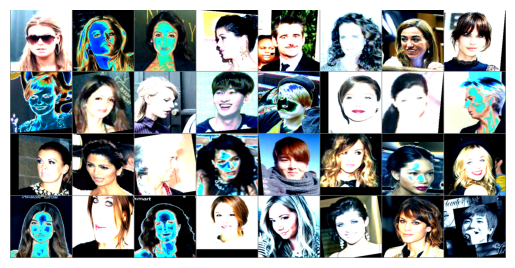

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]


AssertionError: kernel size must be 3 or 7 but got 16

In [ ]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                     [1, 3, 64, 64]       [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                       [1, 3, 64, 64]       [1, 576, 2, 2]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)               [1, 3, 64, 64]       [1, 16, 32, 32]      --                   --                   --                   False
│    │    └─Conv2d (0)                        [1, 3, 64, 64]       [1, 16, 32, 32]      (432)                [3, 3]               442,368              False
│    │    └─BatchNorm2d (1)                   [1, 16, 32, 32]      [1, 16, 32, 32]      (32)                 --                   32                   False
│    │    └─Hardswish (2)                     [1, 

  0%|          | 0/90 [00:00<?, ?it/s]/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)
100%|██████████| 18/18 [00:03<00:00,  5.07it/s]


Epoch: 01 | Epoch Time: 0.0m 41s
	Train Loss: 3.086 | Train Acc: 24.95%
	 Val. Loss: 4.177 |  Val. Acc: 5.09%
Best Accuracy Achieved: 5.09% on epoch 01


100%|██████████| 18/18 [00:02<00:00,  6.24it/s]


Epoch: 02 | Epoch Time: 0.0m 42s
	Train Loss: 2.498 | Train Acc: 33.61%
	 Val. Loss: 1.873 |  Val. Acc: 42.91%
Best Accuracy Achieved: 42.91% on epoch 02


100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


Epoch: 03 | Epoch Time: 0.0m 37s
	Train Loss: 1.449 | Train Acc: 58.07%
	 Val. Loss: 1.255 |  Val. Acc: 60.36%
Best Accuracy Achieved: 60.36% on epoch 03


100%|██████████| 18/18 [00:02<00:00,  7.43it/s]


Epoch: 04 | Epoch Time: 0.0m 29s
	Train Loss: 1.077 | Train Acc: 68.46%
	 Val. Loss: 1.006 |  Val. Acc: 70.73%
Best Accuracy Achieved: 70.73% on epoch 04


100%|██████████| 18/18 [00:02<00:00,  7.53it/s]


Epoch: 05 | Epoch Time: 0.0m 28s
	Train Loss: 0.836 | Train Acc: 75.30%
	 Val. Loss: 0.847 |  Val. Acc: 74.55%
Best Accuracy Achieved: 74.55% on epoch 05


100%|██████████| 18/18 [00:02<00:00,  7.11it/s]


Epoch: 06 | Epoch Time: 0.0m 28s
	Train Loss: 0.730 | Train Acc: 78.56%
	 Val. Loss: 0.821 |  Val. Acc: 77.45%
Best Accuracy Achieved: 77.45% on epoch 06


100%|██████████| 18/18 [00:02<00:00,  7.51it/s]


Epoch: 07 | Epoch Time: 0.0m 28s
	Train Loss: 0.584 | Train Acc: 81.37%
	 Val. Loss: 0.850 |  Val. Acc: 73.45%


100%|██████████| 18/18 [00:02<00:00,  7.24it/s]


Epoch: 08 | Epoch Time: 0.0m 28s
	Train Loss: 0.548 | Train Acc: 83.19%
	 Val. Loss: 0.875 |  Val. Acc: 73.09%


100%|██████████| 18/18 [00:02<00:00,  7.27it/s]


Epoch: 09 | Epoch Time: 0.0m 28s
	Train Loss: 0.510 | Train Acc: 84.25%
	 Val. Loss: 0.837 |  Val. Acc: 76.18%


100%|██████████| 18/18 [00:02<00:00,  7.78it/s]


Epoch: 10 | Epoch Time: 0.0m 28s
	Train Loss: 0.412 | Train Acc: 86.95%
	 Val. Loss: 0.783 |  Val. Acc: 75.27%


100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epoch: 11 | Epoch Time: 0.0m 28s
	Train Loss: 0.365 | Train Acc: 89.09%
	 Val. Loss: 0.719 |  Val. Acc: 79.09%
Best Accuracy Achieved: 79.09% on epoch 11


100%|██████████| 18/18 [00:02<00:00,  7.39it/s]


Epoch: 12 | Epoch Time: 0.0m 28s
	Train Loss: 0.426 | Train Acc: 87.37%
	 Val. Loss: 0.654 |  Val. Acc: 79.45%
Best Accuracy Achieved: 79.45% on epoch 12


100%|██████████| 18/18 [00:02<00:00,  7.35it/s]


Epoch: 13 | Epoch Time: 0.0m 28s
	Train Loss: 0.337 | Train Acc: 89.79%
	 Val. Loss: 0.694 |  Val. Acc: 80.91%
Best Accuracy Achieved: 80.91% on epoch 13


100%|██████████| 18/18 [00:02<00:00,  9.00it/s]


Epoch: 14 | Epoch Time: 0.0m 25s
	Train Loss: 0.314 | Train Acc: 90.07%
	 Val. Loss: 0.683 |  Val. Acc: 81.64%
Best Accuracy Achieved: 81.64% on epoch 14


100%|██████████| 18/18 [00:02<00:00,  8.76it/s]


Epoch: 15 | Epoch Time: 0.0m 24s
	Train Loss: 0.298 | Train Acc: 90.46%
	 Val. Loss: 0.787 |  Val. Acc: 77.64%


100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Epoch: 16 | Epoch Time: 0.0m 24s
	Train Loss: 0.323 | Train Acc: 89.89%
	 Val. Loss: 0.728 |  Val. Acc: 78.55%


100%|██████████| 18/18 [00:02<00:00,  8.97it/s]


Epoch: 17 | Epoch Time: 0.0m 24s
	Train Loss: 0.251 | Train Acc: 91.86%
	 Val. Loss: 0.687 |  Val. Acc: 80.91%


100%|██████████| 18/18 [00:02<00:00,  8.63it/s]


Epoch: 18 | Epoch Time: 0.0m 24s
	Train Loss: 0.266 | Train Acc: 92.04%
	 Val. Loss: 0.609 |  Val. Acc: 82.36%
Best Accuracy Achieved: 82.36% on epoch 18


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Epoch: 19 | Epoch Time: 0.0m 24s
	Train Loss: 0.283 | Train Acc: 91.16%
	 Val. Loss: 0.608 |  Val. Acc: 82.73%
Best Accuracy Achieved: 82.73% on epoch 19


100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Epoch: 20 | Epoch Time: 0.0m 24s
	Train Loss: 0.282 | Train Acc: 91.44%
	 Val. Loss: 0.678 |  Val. Acc: 82.36%


100%|██████████| 18/18 [00:02<00:00,  8.46it/s]


Epoch: 21 | Epoch Time: 0.0m 24s
	Train Loss: 0.240 | Train Acc: 92.63%
	 Val. Loss: 0.599 |  Val. Acc: 82.18%


100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Epoch: 22 | Epoch Time: 0.0m 24s
	Train Loss: 0.196 | Train Acc: 94.21%
	 Val. Loss: 0.677 |  Val. Acc: 82.00%


100%|██████████| 18/18 [00:02<00:00,  8.77it/s]


Epoch: 23 | Epoch Time: 0.0m 24s
	Train Loss: 0.281 | Train Acc: 91.72%
	 Val. Loss: 0.543 |  Val. Acc: 84.18%
Best Accuracy Achieved: 84.18% on epoch 23


100%|██████████| 18/18 [00:02<00:00,  8.86it/s]


Epoch: 24 | Epoch Time: 0.0m 24s
	Train Loss: 0.204 | Train Acc: 93.93%
	 Val. Loss: 0.591 |  Val. Acc: 84.00%


100%|██████████| 18/18 [00:02<00:00,  8.59it/s]


Epoch: 25 | Epoch Time: 0.0m 24s
	Train Loss: 0.199 | Train Acc: 93.54%
	 Val. Loss: 0.520 |  Val. Acc: 85.64%
Best Accuracy Achieved: 85.64% on epoch 25


100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Epoch: 26 | Epoch Time: 0.0m 24s
	Train Loss: 0.245 | Train Acc: 92.39%
	 Val. Loss: 0.535 |  Val. Acc: 83.82%


100%|██████████| 18/18 [00:02<00:00,  8.55it/s]


Epoch: 27 | Epoch Time: 0.0m 24s
	Train Loss: 0.197 | Train Acc: 93.89%
	 Val. Loss: 0.592 |  Val. Acc: 83.82%


100%|██████████| 18/18 [00:01<00:00,  9.57it/s]


Epoch: 28 | Epoch Time: 0.0m 23s
	Train Loss: 0.194 | Train Acc: 93.96%
	 Val. Loss: 0.580 |  Val. Acc: 84.91%


100%|██████████| 18/18 [00:01<00:00, 10.05it/s]


Epoch: 29 | Epoch Time: 0.0m 22s
	Train Loss: 0.138 | Train Acc: 95.68%
	 Val. Loss: 0.440 |  Val. Acc: 87.45%
Best Accuracy Achieved: 87.45% on epoch 29


100%|██████████| 18/18 [00:01<00:00,  9.70it/s]


Epoch: 30 | Epoch Time: 0.0m 22s
	Train Loss: 0.332 | Train Acc: 91.30%
	 Val. Loss: 0.489 |  Val. Acc: 85.09%


100%|██████████| 18/18 [00:01<00:00,  9.84it/s]


Epoch: 31 | Epoch Time: 0.0m 21s
	Train Loss: 0.178 | Train Acc: 94.21%
	 Val. Loss: 0.499 |  Val. Acc: 85.09%


100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


Epoch: 32 | Epoch Time: 0.0m 21s
	Train Loss: 0.147 | Train Acc: 95.47%
	 Val. Loss: 0.544 |  Val. Acc: 84.91%


100%|██████████| 18/18 [00:01<00:00,  9.51it/s]


Epoch: 33 | Epoch Time: 0.0m 21s
	Train Loss: 0.155 | Train Acc: 95.44%
	 Val. Loss: 0.442 |  Val. Acc: 86.73%


100%|██████████| 18/18 [00:01<00:00,  9.87it/s]


Epoch: 34 | Epoch Time: 0.0m 21s
	Train Loss: 0.120 | Train Acc: 95.68%
	 Val. Loss: 0.495 |  Val. Acc: 87.64%
Best Accuracy Achieved: 87.64% on epoch 34


100%|██████████| 18/18 [00:01<00:00, 10.20it/s]


Epoch: 35 | Epoch Time: 0.0m 21s
	Train Loss: 0.153 | Train Acc: 95.40%
	 Val. Loss: 0.546 |  Val. Acc: 86.55%


100%|██████████| 18/18 [00:01<00:00,  9.38it/s]


Epoch: 36 | Epoch Time: 0.0m 21s
	Train Loss: 0.175 | Train Acc: 94.74%
	 Val. Loss: 0.541 |  Val. Acc: 85.27%


100%|██████████| 18/18 [00:01<00:00, 10.37it/s]


Epoch: 37 | Epoch Time: 0.0m 21s
	Train Loss: 0.125 | Train Acc: 95.93%
	 Val. Loss: 0.657 |  Val. Acc: 82.91%


100%|██████████| 18/18 [00:01<00:00, 10.22it/s]


Epoch: 38 | Epoch Time: 0.0m 21s
	Train Loss: 0.202 | Train Acc: 93.79%
	 Val. Loss: 0.539 |  Val. Acc: 87.27%


100%|██████████| 18/18 [00:01<00:00,  9.71it/s]


Epoch: 39 | Epoch Time: 0.0m 21s
	Train Loss: 0.192 | Train Acc: 93.93%
	 Val. Loss: 0.615 |  Val. Acc: 83.45%


100%|██████████| 18/18 [00:01<00:00,  9.85it/s]


Epoch: 40 | Epoch Time: 0.0m 21s
	Train Loss: 0.134 | Train Acc: 96.39%
	 Val. Loss: 0.470 |  Val. Acc: 86.91%


100%|██████████| 18/18 [00:01<00:00,  9.85it/s]


Epoch: 41 | Epoch Time: 0.0m 22s
	Train Loss: 0.145 | Train Acc: 95.02%
	 Val. Loss: 0.714 |  Val. Acc: 82.73%


100%|██████████| 18/18 [00:01<00:00, 10.00it/s]


Epoch: 42 | Epoch Time: 0.0m 22s
	Train Loss: 0.213 | Train Acc: 93.82%
	 Val. Loss: 0.657 |  Val. Acc: 82.55%


100%|██████████| 18/18 [00:01<00:00, 10.32it/s]


Epoch: 43 | Epoch Time: 0.0m 21s
	Train Loss: 0.128 | Train Acc: 95.86%
	 Val. Loss: 0.541 |  Val. Acc: 84.91%


100%|██████████| 18/18 [00:01<00:00, 11.77it/s]


Epoch: 44 | Epoch Time: 0.0m 21s
	Train Loss: 0.138 | Train Acc: 95.93%
	 Val. Loss: 0.576 |  Val. Acc: 85.82%


100%|██████████| 18/18 [00:01<00:00, 12.08it/s]


Epoch: 45 | Epoch Time: 0.0m 19s
	Train Loss: 0.233 | Train Acc: 93.09%
	 Val. Loss: 0.496 |  Val. Acc: 86.36%


100%|██████████| 18/18 [00:01<00:00, 12.03it/s]


Epoch: 46 | Epoch Time: 0.0m 19s
	Train Loss: 0.130 | Train Acc: 95.58%
	 Val. Loss: 0.594 |  Val. Acc: 83.82%


100%|██████████| 18/18 [00:01<00:00, 12.23it/s]


Epoch: 47 | Epoch Time: 0.0m 19s
	Train Loss: 0.226 | Train Acc: 92.91%
	 Val. Loss: 0.569 |  Val. Acc: 83.82%


100%|██████████| 18/18 [00:01<00:00, 12.22it/s]


Epoch: 48 | Epoch Time: 0.0m 19s
	Train Loss: 0.158 | Train Acc: 95.05%
	 Val. Loss: 0.541 |  Val. Acc: 86.00%


100%|██████████| 18/18 [00:01<00:00, 11.91it/s]


Epoch: 49 | Epoch Time: 0.0m 19s
	Train Loss: 0.166 | Train Acc: 94.91%
	 Val. Loss: 0.488 |  Val. Acc: 86.36%


100%|██████████| 18/18 [00:01<00:00, 12.08it/s]


Epoch: 50 | Epoch Time: 0.0m 19s
	Train Loss: 0.133 | Train Acc: 96.14%
	 Val. Loss: 0.500 |  Val. Acc: 87.27%


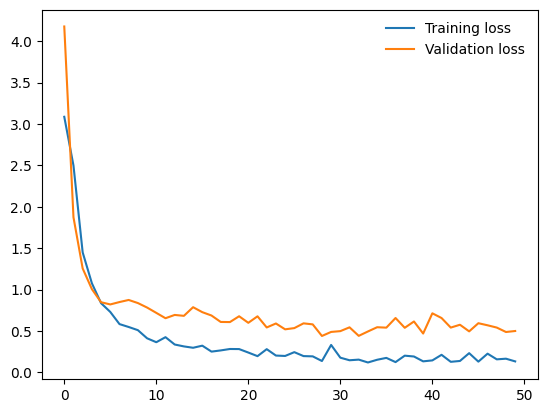

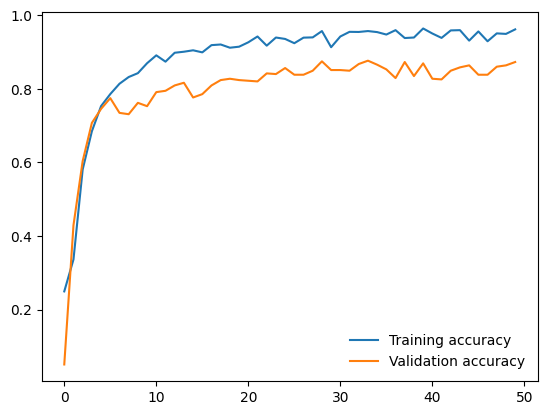

In [ ]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/cb13f2fa78a04e0c808061444e12d202
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.006504149436950684
COMET INFO:     test_accuracy   : 0.875
COMET INFO:     test_loss       : 0.6080452466011047
COMET INFO:     train_acc [50]  : (0.2494736909866333, 0.9638596773147583)
COMET INFO:     train_loss [50] : (0.12007848741846126, 3.086335336450945)
COMET INFO:     val_acc [50]    : (0.05090909078717232, 0.8763636350631714)
COMET INFO:     val_loss [50]   : (0.4401733181693337, 4.176793006550182)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobilenet_v3_small at 0x13b3b0040>
COMET INFO:     batch_size      : 16
COMET INFO:     data_path       : /Users/leo/Desk

Test loss: 0.608.. 
Test accuracy: 0.875
Test Time: 0.0m 1s 300ms


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


(0.6080452466011047, tensor(0.8750, device='mps:0'))